# Setup

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
# Add folder to path
import sys
src_path = '../../code' 
sys.path.insert(0, src_path) 

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from numpy.random import dirichlet, gamma, multinomial, normal 

In [5]:
data_df = pd.read_csv("../../data/raw/speed_dating_data.csv", encoding="ISO-8859-1")
data_df.head(1)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [6]:
#for col in data_df.columns:
#    print(col)

In [8]:
# remove duplicate dates
data_m_df = data_df[data_df["gender"] == 1]
data_m_df.shape

(4194, 195)

In [323]:
# extract age differences
ageDiff_df = data_m_df[["age", "age_o", "match"]]
ageDiff_df = ageDiff_df.assign(ageDiff = ageDiff_df["age"] - ageDiff_df["age_o"])

# drop examples with nan values
ageDiff_df = ageDiff_df.dropna()

print(ageDiff_df.shape)
ageDiff_df.head()

(4090, 4)


,age,age_o,match,ageDiff
100,27.0,21.0,0,6.0
101,27.0,24.0,0,3.0
102,27.0,25.0,0,2.0
103,27.0,23.0,0,4.0
104,27.0,21.0,0,6.0


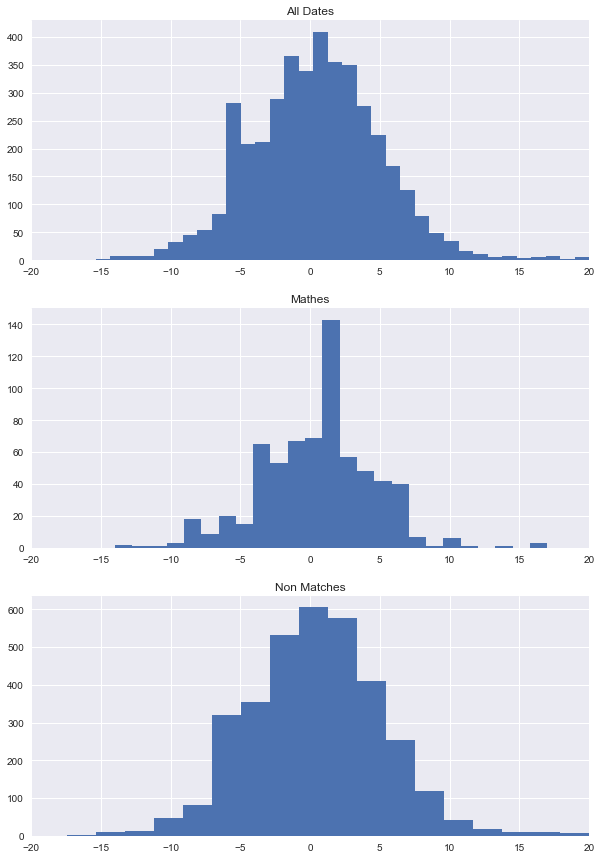

In [412]:
match_idx = ageDiff_df["match"] == 1
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.hist(ageDiff_df["ageDiff"], bins=50)
plt.xlim([-20,20])
plt.title("All Dates")

plt.subplot(3,1,2)
plt.hist(ageDiff_df.loc[match_idx,"ageDiff"], bins=25)
plt.xlim([-20,20])
plt.title("Mathes")

plt.subplot(3,1,3)
plt.hist(ageDiff_df.loc[~match_idx,"ageDiff"], bins=25)
plt.xlim([-20,20])
plt.title("Non Matches")

plt.show()

In [401]:
print("No match mean :", np.mean(ageDiff_df.loc[ageDiff_df["match"] == 0, "ageDiff"]))
print("No match std  :", np.std(ageDiff_df.loc[ageDiff_df["match"] == 0, "ageDiff"]))
print("No match count:", len(ageDiff_df.loc[ageDiff_df["match"] == 0, "ageDiff"]))
print("Match mean    :", np.mean(ageDiff_df.loc[ageDiff_df["match"] == 1, "ageDiff"]))
print("Match std     :", np.std(ageDiff_df.loc[ageDiff_df["match"] == 1, "ageDiff"]))
print("Match count   :", len(ageDiff_df.loc[ageDiff_df["match"] == 1, "ageDiff"]))

No match mean : 0.5228203627852546
No match std  : 4.854185094839605
No match count: 3418
Match mean    : 0.5297619047619048
Match std     : 4.118303504215602
Match count   : 672


In [402]:
import math
def normpdf(x, mean, tau):
    var = 1/tau
    pi = 3.1415926
    denom = (2*pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

# Initiate Model

In [403]:
X = ageDiff_df["ageDiff"].values
y = ageDiff_df["match"].values

In [404]:
iterations = 200
n_classes = 2
n_examples = X.shape[0]

In [405]:
# Initiate variables

# hyperparameters
alpha_pi = [1,1] # paramaterizes dirichlet over pi's
alpha_mu = 0     # paramaterizes guassian over mu's
alpha_tau = 1    # paramaterizes gamma over tau's
beta_tau = 1     # paramaterizes gamma over tau's

# latent variables
pi = dirichlet(alpha_pi) # paramaterizes discrete of z's
mu_vec = np.zeros(2)     # paramaterizes gaussians over x's
tau_vec = np.zeros(2)    # paramaterizes gaussians over x's
for i in range(n_classes):
    mu_vec[i] = normal(alpha_mu, scale=1.0)
    tau_vec[i] = gamma(alpha_tau, 1.0/beta_tau)

z_vec = np.zeros((n_examples, n_classes))
for i in range(n_examples):
    z_vec[i,:] = multinomial(n=1, pvals=pi)

In [406]:
print(pi)
print(mu_vec)
print(tau_vec)

[ 0.97194755  0.02805245]
[ 1.11740705  0.4444171 ]
[ 1.71601953  1.22603091]


# Gibbs Sampling

In [421]:
for iteration in range(1):

    # update pi
    param_update = pi_beta + np.sum(z_vec, axis=0)
    pi = dirichlet(param_update)

    # update mu's
    for i in range(n_classes):
        c_idx = z_vec[:,i] == 1
        c_examples = np.sum(c_idx)

        param1_update = (mu_vec[i] + tau_vec[i]*np.sum(X[c_idx])) / (1 + c_examples*tau_vec[i])
        param2_update = 1 + c_examples*tau_vec[i]

        mu_vec[i] = normal(param1_update, 1/param2_update)
    
    # update tau's
    for i in range(n_classes):
        c_idx = z_vec[:,i] == 1
        c_examples = np.sum(c_idx)

        param1_update = alpha_tau + (c_examples / 2)
        param2_update = beta_tau + (np.sum( (X[c_idx] - mu_vec[i])**2 )) / 2

        tau_vec[i] = gamma(param1_update, 1.0/param2_update)
   
    # update latent classes
    for i in range(n_examples):

        # likelihood of class 0
        likelihood_0 = normpdf(X[i], mu_vec[0], tau_vec[0])
        # prior of class 0
        prior_0 = pi[0]

        # likelihood of class 1
        likelihood_1 = normpdf(X[i], mu_vec[1], tau_vec[1])
        # prior of class 1
        prior_1 = pi[1]

        # marginal likelihood
        Z = (likelihood_0 * prior_0) + (likelihood_1 * prior_1)

        # probability of class 0
        prob_0 = (likelihood_0 * prior_0) / Z
        # probability of class 1
        prob_1 = (likelihood_1 * prior_1) / Z

        # sample from updated multinomial distribution
        z_vec[i,:] = multinomial(n=1, pvals=[prob_0, prob_1])

In [422]:
print("updated pi     :", pi)
print("updated mu_vec :", mu_vec)
print("updated tau_vec:", tau_vec)

updated pi     : [ 0.31555768  0.68444232]
updated mu_vec : [-0.30573323  0.88356661]
updated tau_vec: [ 0.02542973  0.07635834]


# Model Analysis

In [409]:
df = pd.DataFrame(np.hstack((
    X.reshape(-1,1), 
    z_vec[:,0].reshape(-1,1),
    y.reshape(-1,1))))
df.columns = ['ageDiff', 'latentClass', 'match']
df.head()

,ageDiff,latentClass,match
0,6.0,0.0,0.0
1,3.0,1.0,0.0
2,2.0,1.0,0.0
3,4.0,1.0,0.0
4,6.0,0.0,0.0


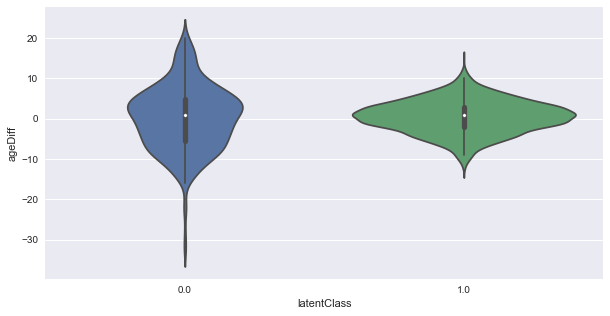

In [348]:
plt.figure(figsize=(10,5))
sns.violinplot(x="latentClass", y="ageDiff", data=df)
plt.show()